/opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


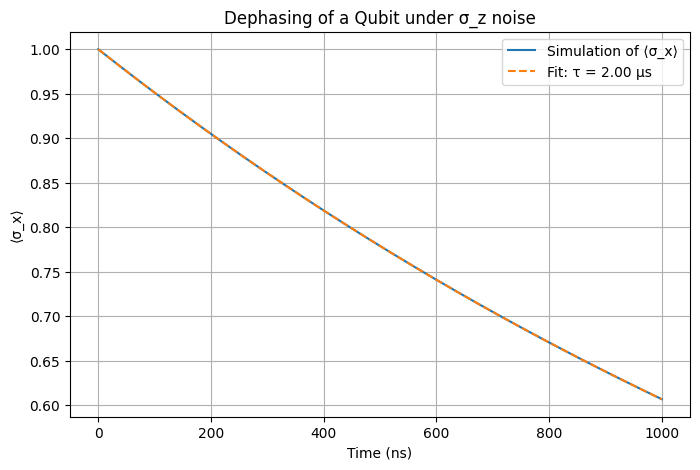

np.float64(2000.000274104428)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Set parameters
gamma = 1 / 1000  # Dephasing rate (1/T2), T2 = 10ns
t_max = 1/gamma
N = int(t_max)
t_list = np.linspace(0, t_max, N)  # Time points for simulation (up to 50000 ns)
initial_state = (basis(2, 0) + basis(2, 1)).unit()  # + state (1/sqrt(2)) * (|0> + |1>)
sigma_x = sigmax()
sigma_z = sigmaz()

# Define the Lindblad operator for dephasing (sigmaz)
H = 0 * sigmaz()  # No Hamiltonian (isolated qubit), but needs to be a Qobj
L = np.sqrt(gamma) * Qobj([[0, 0], [0, 1]])  # Lindblad operator

# Define the Liouvillian (Lindblad equation)
c_ops = [L]  # Collapse operators list for mesolve

# Time evolution using the mesolve function
result = mesolve(H, initial_state, t_list, c_ops, [sigma_x])

# Get the average value of sigma_x
avg_sigma_x = result.expect[0]

# Fit the decay with an exponential function
from scipy.optimize import curve_fit

def exp_decay(t, tau):
    return np.exp(-t / tau)

params, covariance = curve_fit(exp_decay, t_list, avg_sigma_x, p0=[10000])

# Plot the result
plt.figure(figsize=(8, 5))
plt.plot(t_list, avg_sigma_x, label="Simulation of ⟨σ_x⟩")
plt.plot(t_list, exp_decay(t_list, *params), label=f"Fit: τ = {params[0]/1000:.2f} μs", linestyle="--")
plt.xlabel("Time (ns)")
plt.ylabel("⟨σ_x⟩")
plt.title("Dephasing of a Qubit under σ_z noise")
plt.legend()
plt.grid(True)
plt.show()

# Return the fitted decay time in nanoseconds
params[0]  # Decay time tau from the fit in nanoseconds


In [2]:
from noise_generator import GenerateNoise

In [3]:
sample_rate = 1               # per ns
t_max = int(1e3)             # number of samples
S0 = np.sqrt(gamma)
relative_PSD_strength = S0**2
num_realizations = 2000
ifwhite = True                # True for white noise, False for 1/f noise
# Generate white noise (unit variance) trajectories
N = t_max * sample_rate
gn = GenerateNoise(sample_rate, t_max, relative_PSD_strength, num_realizations, ifwhite)

In [226]:
trajs = gn.generate_colored_noise()

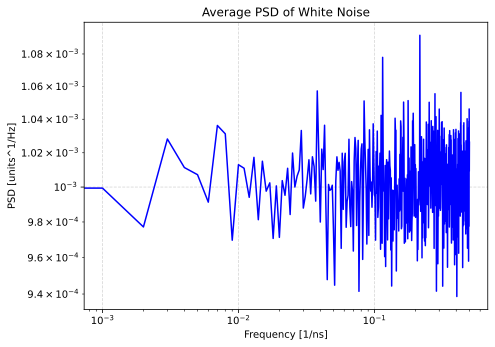

Sanity Checks (white noise):
Median raw periodogram / (S0 ): 1.001538
Std dev of integrated phase / sqrt(S0 * t_max): 0.986765


{'freqs': array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
        0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
        0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
        0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
        0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
        0.045, 0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053,
        0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062,
        0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071,
        0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 ,
        0.081, 0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089,
        0.09 , 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098,
        0.099, 0.1  , 0.101, 0.102, 0.103, 0.104, 0.105, 0.106, 0.107,
        0.108, 0.109, 0.11 , 0.111, 0.112, 0.113, 0.114, 0.115, 0.116,
        0.117, 0.118, 0.119, 0.12 , 0.121, 0.122, 0.123, 0.124, 0.12

In [227]:
gn.analyze_noise_psd(trajs)

In [228]:
# Perform quantum simulation with noise trajectories
from qutip import sesolve, basis, sigmaz, sigmax

# Initialize arrays to store results
all_expect_values = []
time_points = np.linspace(0, t_max, N)  # Time points matching noise trajectory

# Initial state from file_context_0
initial_state = (basis(2, 0) + basis(2, 1)).unit()  # + state (1/sqrt(2)) * (|0> + |1>)
sigma_x = sigmax()
sigma_z = -sigmaz()

# Loop through each noise trajectory
for i in range(num_realizations):
    # Create time-dependent Hamiltonian with noise
    H = [[Qobj([[0, 0], [0, 1]]), lambda t, args: trajs[i][int(t * sample_rate)] if t < t_max else 0]]
    
    # Solve the dynamics
    result = sesolve(H, initial_state, time_points, e_ops=[sigma_x])
    
    # Store the expectation values
    all_expect_values.append(result.expect[0])

# Convert to numpy array for easier analysis
all_expect_values = np.array(all_expect_values)


capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/qutip/solver/integrator/scipy_integrator.py", line 71, in _mul_np_vec
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
    return out.as_ndarray().ravel()
           ^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


: 

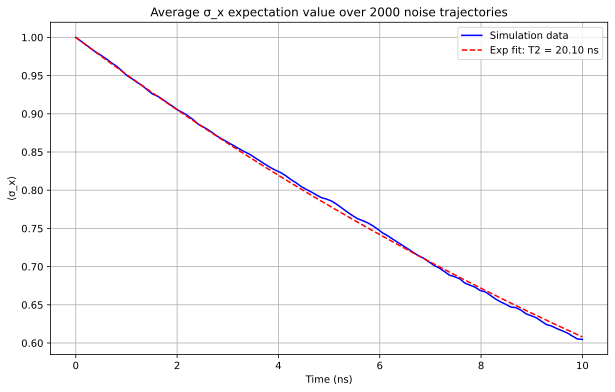

Fitted T2 time = 20.0983 ns


(100,)

In [174]:
# Calculate the average over all trajectories
avg_sigmax = np.mean(all_expect_values, axis=0)

# Define exponential decay function for fitting
def exp_decay(t, T2):
    return np.exp(-t / T2)  # No amplitude parameter

# Fit the data with exponential decay
from scipy.optimize import curve_fit
params, pcov = curve_fit(exp_decay, time_points, avg_sigmax, p0=[500])
T2_fit = params[0]

# Plot the results with the fit
plt.figure(figsize=(10, 6))
plt.plot(time_points, avg_sigmax, 'b-', label='Simulation data')
plt.plot(time_points, exp_decay(time_points, T2_fit), 'r--', 
         label=f'Exp fit: T2 = {T2_fit:.2f} ns')
plt.xlabel('Time (ns)')
plt.ylabel('⟨σ_x⟩')
plt.title(f'Average σ_x expectation value over {num_realizations} noise trajectories')
plt.legend()
plt.grid(True)
plt.show()

# Print the fitted parameters
print(f"Fitted T2 time = {T2_fit:.4f} ns")

# Return the shape of the results array
avg_sigmax.shape

In [4]:
from hamiltonian_generator import Hamiltonian
import qutip as qt


phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
A = 5e-3 * 2 * np.pi
optimal_omega = sc.optimal_omegad(A)[0]*2*np.pi

sc = Hamiltonian(phi_ex, Ej, Ec, [2,1])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
# Make diagonal term subtract the first element
noise_matrix = sc.noise.copy()
first_element = noise_matrix[0, 0]
for i in range(noise_matrix.shape[0]):
    noise_matrix[i, i] -= first_element
noise = noise_matrix
noise = qt.Qobj(sc.noise)


In [6]:
noise_matrix = sc.noise.copy()
first_element = noise_matrix[0, 0]
for i in range(noise_matrix.shape[0]):
    noise_matrix[i, i] -= first_element
noise = qt.Qobj(noise_matrix)


In [7]:
noise

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.00000000e+00 1.41416534e-14]
 [1.41416534e-14 2.40559203e+01]]

 /opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/qutip/solver/solver_base.py: 576

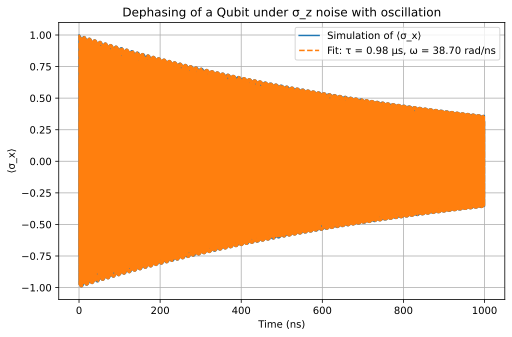

Decay time: 984.99 ns
Oscillation frequency: 38.6987 rad/ns


np.float64(984.9903961185478)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Set parameters
expected_gamma = 1 / 1000
gamma = expected_gamma / (noise.full()[1,1]**2)  # Dephasing rate (1/T2), T2 = 10ns
t_list = np.linspace(0, 1000, 10000)  # Time points for simulation (up to 50000 ns)
initial_state = (basis(2, 0) + basis(2, 1)).unit()  # + state (1/sqrt(2)) * (|0> + |1>)
sigma_x = sigmax()
sigma_z = sigmaz()

# Define the Lindblad operator for dephasing (sigmaz)
# Time-dependent Hamiltonian with driving term

H = [H0, [H_control, lambda t, args: 0 * np.cos(optimal_omega * t)]]  # Time-dependent Hamiltonian
L = noise * np.sqrt(2*gamma)  # Lindblad operator with noise

# Define the Liouvillian (Lindblad equation)
c_ops = [L]  # Collapse operators list for mesolve

# Time evolution using the mesolve function
result = mesolve(H, initial_state, t_list, c_ops, [sigma_x])

# Get the average value of sigma_x
avg_sigma_x = result.expect[0]

# Fit the decay with an exponential function
from scipy.optimize import curve_fit
def exp_decay_with_oscillation(t, tau, w):
    return np.exp(-t / tau) * np.cos(w * t)

# Initial guess for parameters: tau, w
initial_guess = [2/expected_gamma, 38.693]
params, covariance = curve_fit(exp_decay_with_oscillation, t_list, avg_sigma_x, p0=initial_guess)

# Extract fitted parameters
tau, w = params

# Plot the result
plt.figure(figsize=(8, 5))
plt.plot(t_list, avg_sigma_x, label="Simulation of ⟨σ_x⟩")
plt.plot(t_list, exp_decay_with_oscillation(t_list, *params), 
         label=f"Fit: τ = {tau/1000:.2f} μs, ω = {w:.2f} rad/ns", 
         linestyle="--")
plt.xlabel("Time (ns)")
plt.ylabel("⟨σ_x⟩")
plt.title("Dephasing of a Qubit under σ_z noise with oscillation")
plt.legend()
plt.grid(True)
plt.show()

# Return the fitted parameters
print(f"Decay time: {tau:.2f} ns")
print(f"Oscillation frequency: {w:.4f} rad/ns")
tau  # Return the decay time in nanoseconds


In [10]:
L**2/2

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[3.45687689e-34 5.87865824e-19]
 [5.87865824e-19 1.00000000e-03]]

 /opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/qutip/solver/solver_base.py: 576

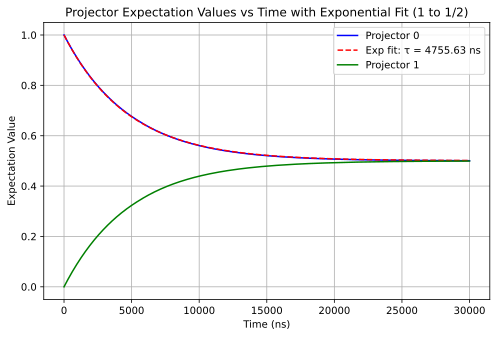

Fit parameter: τ = 4755.6253 ns
R-squared: 0.999917
Average sum of projectors: 0.999998
Min sum: 0.999996, Max sum: 1.000000


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

t_list = np.linspace(0, 30000, 10000)  # Time points for simulation (up to 50000 ns)

# Define the Lindblad operator for dephasing (sigmaz)
# Time-dependent Hamiltonian with driving term

H = [H0, [H_control, lambda t, args: A * np.cos(optimal_omega * t)]]  # Time-dependent Hamiltonian
L = noise * np.sqrt(2*gamma)  # Lindblad operator with noise

# Define the Liouvillian (Lindblad equation)
c_ops = [L]  # Collapse operators list for mesolve

_, state_and_sigmax, get_projector = sc.setup_floquet_system(A , optimal_omega)
U_init , _ = state_and_sigmax(0)
init_state = U_init[:,0]
init_state = qt.Qobj(init_state)

# Time evolution using the mesolve function
result = mesolve(H, init_state, t_list, c_ops, [])

# Calculate projector averages for each time point
avg_values = np.zeros((2, len(t_list)))
for i, t in enumerate(t_list):
    # Get the state at time t
    state_t = result.states[i]
    
    # Get the projector at time t
    U, _ = state_and_sigmax(t)
    projectors = get_projector(U)
    
    # Calculate expectation values for both projectors
    avg_values[0, i] = expect(projectors[0], state_t)
    avg_values[1, i] = expect(projectors[1], state_t)

# Plot the projector averages and fit projector 0 with exponential
from scipy.optimize import curve_fit

# Define exponential decay function that decays from 1 to 1/2
def exp_decay(t, tau):
    return 0.5 + 0.5 * np.exp(-t/tau)

# Fit projector 0 data with modified exponential decay
try:
    # Scale data to match our function range (1 to 0.5)
    max_val = avg_values[0][0]
    min_val = np.min(avg_values[0])
    target_range = 0.5  # We want to decay from 1 to 0.5 (range of 0.5)
    actual_range = max_val - min_val
    
    # Normalize data for fitting
    normalized_data = 0.5 + 0.5 * (avg_values[0] - min_val) / (max_val - min_val)
    
    # Fit with our modified exponential
    popt, pcov = curve_fit(exp_decay, t_list, normalized_data, p0=[10])
    tau_fit = popt[0]
    fit_curve = exp_decay(t_list, tau_fit)
    
    # Calculate R-squared
    residuals = normalized_data - fit_curve
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((normalized_data - np.mean(normalized_data))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Plot data and fit
    plt.figure(figsize=(8, 5))
    plt.plot(t_list, avg_values[0], 'b-', label="Projector 0")
    
    # Scale the fit curve back to original data range for plotting
    scaled_fit = min_val + (fit_curve - 0.5) * 2 * (max_val - min_val)
    plt.plot(t_list, scaled_fit, 'r--', label=f"Exp fit: τ = {tau_fit:.2f} ns")
    
    plt.plot(t_list, avg_values[1], 'g-', label="Projector 1")
    plt.xlabel("Time (ns)")
    plt.ylabel("Expectation Value")
    plt.title("Projector Expectation Values vs Time with Exponential Fit (1 to 1/2)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Fit parameter: τ = {tau_fit:.4f} ns")
    print(f"R-squared: {r_squared:.6f}")
except Exception as e:
    print(f"Fitting error: {e}")
    # Fall back to original plot if fitting fails
    plt.figure(figsize=(8, 5))
    plt.plot(t_list, avg_values[0], label="Projector 0")
    plt.plot(t_list, avg_values[1], label="Projector 1")
    plt.xlabel("Time (ns)")
    plt.ylabel("Expectation Value")
    plt.title("Projector Expectation Values vs Time")
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate the sum to verify they add to 1 (or close to 1 due to numerical precision)
sum_projectors = avg_values[0] + avg_values[1]
print(f"Average sum of projectors: {np.mean(sum_projectors):.6f}")
print(f"Min sum: {np.min(sum_projectors):.6f}, Max sum: {np.max(sum_projectors):.6f}")


 /opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/qutip/solver/solver_base.py: 576

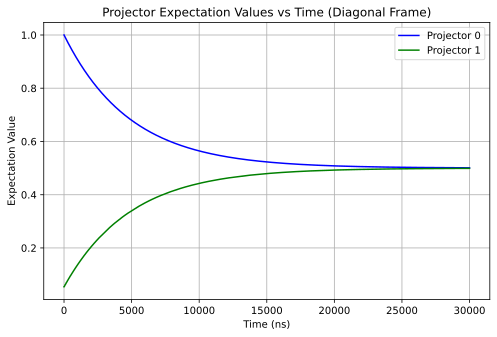

Average sum of projectors: 1.008793


In [17]:
# Go to the rotating frame of drive and diagonalize

from system import *

# Diagonalize the rotating frame Hamiltonian
H0_rot = H0.full() - optimal_omega * np.diag(np.arange(H0.shape[0])) + A/2 * H_control.full()
evals_rot, U_diag = np.linalg.eigh(H0_rot)
evals_rot, U_diag = sort_eigenpairs(evals_rot, U_diag)
Ud_diag = U_diag.T.conj()

# Set parameters for simulation
t_list_diag = np.linspace(0, 30000, 10000)  # Time points for simulation
H_diag = qt.Qobj(np.diag(evals_rot))  # Diagonal Hamiltonian
L = noise * np.sqrt(2*gamma)  # Same Lindblad operator as before
c_ops = [L]  # Collapse operators list

# Initial state in the diagonalized frame
init_state_diag = qt.Qobj(U_diag[:,0])

# Time evolution using the mesolve function
result_diag = mesolve(qt.Qobj(H0_rot), init_state_diag, t_list_diag, c_ops, [])

# Calculate projector averages for each time point
avg_values_diag = np.zeros((2, len(t_list_diag)))
projectors_diag = [init_state_diag * init_state_diag.dag(), qt.projection(2, 1, 1)]  # Using initial state projector

for i, t in enumerate(t_list_diag):
    # Get the state at time t
    state_t = result_diag.states[i]
    
    # Calculate expectation values for both projectors
    avg_values_diag[0, i] = expect(projectors_diag[0], state_t)
    avg_values_diag[1, i] = expect(projectors_diag[1], state_t)

# Plot the projector averages
plt.figure(figsize=(8, 5))
plt.plot(t_list_diag, avg_values_diag[0], 'b-', label="Projector 0")
plt.plot(t_list_diag, avg_values_diag[1], 'g-', label="Projector 1")
plt.xlabel("Time (ns)")
plt.ylabel("Expectation Value")
plt.title("Projector Expectation Values vs Time (Diagonal Frame)")
plt.legend()
plt.grid(True)
plt.show()

# Calculate the sum to verify they add to 1
sum_projectors_diag = avg_values_diag[0] + avg_values_diag[1]
print(f"Average sum of projectors: {np.mean(sum_projectors_diag):.6f}")

 /opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/qutip/solver/solver_base.py: 576

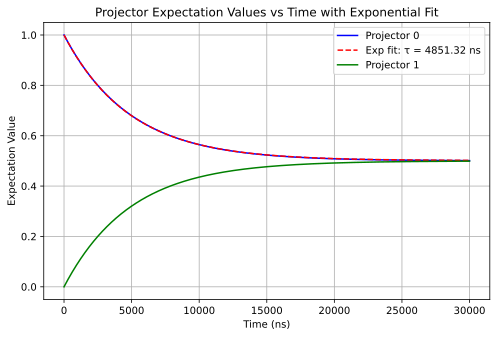

Fit parameter: τ = 4851.3225 ns
R-squared: 0.999966
Average sum of projectors: 1.000000


In [18]:
# Go to the rotating frame of drive and diagonalize

from system import *

# Diagonalize the rotating frame Hamiltonian
H0_rot = H0.full() - optimal_omega * np.diag(np.arange(H0.shape[0])) + A/2 * H_control.full()
evals_rot, U_diag = np.linalg.eigh(H0_rot)
evals_rot, U_diag = sort_eigenpairs(evals_rot, U_diag)
Ud_diag = U_diag.T.conj()


H_diag = qt.Qobj(np.diag(evals_rot))  # Diagonal Hamiltonian
L = noise * np.sqrt(2*gamma)  # Same Lindblad operator as before
L_rot_diag = Ud_diag @ L.full() @ U_diag
# Separate diagonal and off-diagonal terms of the Lindblad operator in the diagonal frame
L_diag = np.diag(np.diag(L_rot_diag))  # Diagonal terms
L_off_diag = L_rot_diag - L_diag  # Off-diagonal terms

# Create QutipObjects for the operators
L_diag_op = qt.Qobj(L_diag)
# Split off-diagonal terms into raising and lowering operators
L_off_diag_plus = np.zeros_like(L_off_diag)
L_off_diag_minus = np.zeros_like(L_off_diag)
L_off_diag_plus[0, 1] = L_off_diag[0, 1]  # Only keep the raising term (0->1)
L_off_diag_minus[1, 0] = L_off_diag[1, 0]  # Only keep the lowering term (1->0)
L_off_diag_op_plus = qt.Qobj(L_off_diag_plus)
L_off_diag_op_minus = qt.Qobj(L_off_diag_minus)

# Add all three operators to the collapse operators list
c_ops = [L_diag_op, L_off_diag_op_plus, L_off_diag_op_minus]

# Initial state in the diagonalized frame
init_state_diag = qt.basis(2, 0)

# Time evolution using the mesolve function
result_diag = mesolve(H_diag, init_state_diag, t_list_diag, c_ops, [])

# Calculate projector averages for each time point
avg_values_diag = np.zeros((2, len(t_list_diag)))
projectors_diag = [init_state_diag * init_state_diag.dag(), qt.projection(2, 1, 1)]  # Using initial state projector

for i, t in enumerate(t_list_diag):
    # Get the state at time t
    state_t = result_diag.states[i]
    
    # Calculate expectation values for both projectors
    avg_values_diag[0, i] = expect(projectors_diag[0], state_t)
    avg_values_diag[1, i] = expect(projectors_diag[1], state_t)

# Define exponential decay function for fitting
def exp_decay(t, tau):
    return 0.5 + 0.5 * np.exp(-t / tau)

# Fit projector 0 data with modified exponential decay
try:
    # Scale data to match our function range (1 to 0.5)
    max_val = avg_values_diag[0][0]
    min_val = np.min(avg_values_diag[0])
    
    # Normalize data for fitting
    normalized_data = 0.5 + 0.5 * (avg_values_diag[0] - min_val) / (max_val - min_val)
    
    # Fit with our modified exponential
    popt, pcov = curve_fit(exp_decay, t_list_diag, normalized_data, p0=[10])
    tau_fit = popt[0]
    fit_curve = exp_decay(t_list_diag, tau_fit)
    
    # Calculate R-squared
    residuals = normalized_data - fit_curve
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((normalized_data - np.mean(normalized_data))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Plot data and fit
    plt.figure(figsize=(8, 5))
    plt.plot(t_list_diag, avg_values_diag[0], 'b-', label="Projector 0")
    
    # Scale the fit curve back to original data range for plotting
    scaled_fit = min_val + (fit_curve - 0.5) * 2 * (max_val - min_val)
    plt.plot(t_list_diag, scaled_fit, 'r--', label=f"Exp fit: τ = {tau_fit:.2f} ns")
    
    plt.plot(t_list_diag, avg_values_diag[1], 'g-', label="Projector 1")
    plt.xlabel("Time (ns)")
    plt.ylabel("Expectation Value")
    plt.title("Projector Expectation Values vs Time with Exponential Fit")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Fit parameter: τ = {tau_fit:.4f} ns")
    print(f"R-squared: {r_squared:.6f}")
except Exception as e:
    print(f"Fitting error: {e}")
    # Fall back to original plot if fitting fails
    plt.figure(figsize=(8, 5))
    plt.plot(t_list_diag, avg_values_diag[0], 'b-', label="Projector 0")
    plt.plot(t_list_diag, avg_values_diag[1], 'g-', label="Projector 1")
    plt.xlabel("Time (ns)")
    plt.ylabel("Expectation Value")
    plt.title("Projector Expectation Values vs Time (Diagonal Frame)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate the sum to verify they add to 1
sum_projectors_diag = avg_values_diag[0] + avg_values_diag[1]
print(f"Average sum of projectors: {np.mean(sum_projectors_diag):.6f}")

 /opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/qutip/solver/solver_base.py: 576

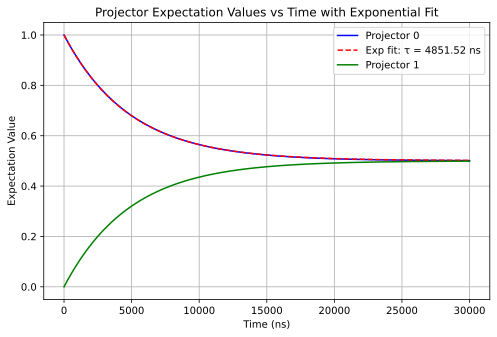

Fit parameter: τ = 4851.5190 ns
R-squared: 0.999966
Average sum of projectors: 1.000000


In [19]:
# Go to the rotating frame of drive and diagonalize

from system import *

# Diagonalize the rotating frame Hamiltonian
H0_rot = H0.full() - optimal_omega * np.diag(np.arange(H0.shape[0])) + A/2 * H_control.full()
evals_rot, U_diag = np.linalg.eigh(H0_rot)
evals_rot, U_diag = sort_eigenpairs(evals_rot, U_diag)
Ud_diag = U_diag.T.conj()

H_diag = qt.Qobj(np.diag(evals_rot))  # Diagonal Hamiltonian
L = noise * np.sqrt(2*gamma)  # Same Lindblad operator as before
L_rot_diag = Ud_diag @ L.full() @ U_diag
# Separate diagonal and off-diagonal terms of the Lindblad operator in the diagonal frame
L_diag = np.diag(np.diag(L_rot_diag))  # Diagonal terms
L_off_diag = L_rot_diag - L_diag  # Off-diagonal terms

# Create QutipObjects for the operators
L_diag_op = qt.Qobj(L_diag)
# Split off-diagonal terms into raising and lowering operators
L_off_diag_plus = np.zeros_like(L_off_diag)
L_off_diag_minus = np.zeros_like(L_off_diag)
L_off_diag_plus[0, 1] = L_off_diag[0, 1]  # Only keep the raising term (0->1)
L_off_diag_minus[1, 0] = L_off_diag[1, 0]  # Only keep the lowering term (1->0)
L_off_diag_op_plus = qt.Qobj(L_off_diag_plus)
L_off_diag_op_minus = qt.Qobj(L_off_diag_minus)

# Add all three operators to the collapse operators list
c_ops = [qt.Qobj(L_rot_diag)]

# Initial state in the diagonalized frame
init_state_diag = qt.basis(2, 0)

# Time evolution using the mesolve function
result_diag = mesolve(H_diag, init_state_diag, t_list_diag, c_ops, [])

# Calculate projector averages for each time point
avg_values_diag = np.zeros((2, len(t_list_diag)))
projectors_diag = [init_state_diag * init_state_diag.dag(), qt.projection(2, 1, 1)]  # Using initial state projector

for i, t in enumerate(t_list_diag):
    # Get the state at time t
    state_t = result_diag.states[i]
    
    # Calculate expectation values for both projectors
    avg_values_diag[0, i] = expect(projectors_diag[0], state_t)
    avg_values_diag[1, i] = expect(projectors_diag[1], state_t)

# Define exponential decay function for fitting
def exp_decay(t, tau):
    return 0.5 + 0.5 * np.exp(-t / tau)

# Fit projector 0 data with modified exponential decay
try:
    # Scale data to match our function range (1 to 0.5)
    max_val = avg_values_diag[0][0]
    min_val = np.min(avg_values_diag[0])
    
    # Normalize data for fitting
    normalized_data = 0.5 + 0.5 * (avg_values_diag[0] - min_val) / (max_val - min_val)
    
    # Fit with our modified exponential
    popt, pcov = curve_fit(exp_decay, t_list_diag, normalized_data, p0=[10])
    tau_fit = popt[0]
    fit_curve = exp_decay(t_list_diag, tau_fit)
    
    # Calculate R-squared
    residuals = normalized_data - fit_curve
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((normalized_data - np.mean(normalized_data))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Plot data and fit
    plt.figure(figsize=(8, 5))
    plt.plot(t_list_diag, avg_values_diag[0], 'b-', label="Projector 0")
    
    # Scale the fit curve back to original data range for plotting
    scaled_fit = min_val + (fit_curve - 0.5) * 2 * (max_val - min_val)
    plt.plot(t_list_diag, scaled_fit, 'r--', label=f"Exp fit: τ = {tau_fit:.2f} ns")
    
    plt.plot(t_list_diag, avg_values_diag[1], 'g-', label="Projector 1")
    plt.xlabel("Time (ns)")
    plt.ylabel("Expectation Value")
    plt.title("Projector Expectation Values vs Time with Exponential Fit")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Fit parameter: τ = {tau_fit:.4f} ns")
    print(f"R-squared: {r_squared:.6f}")
except Exception as e:
    print(f"Fitting error: {e}")
    # Fall back to original plot if fitting fails
    plt.figure(figsize=(8, 5))
    plt.plot(t_list_diag, avg_values_diag[0], 'b-', label="Projector 0")
    plt.plot(t_list_diag, avg_values_diag[1], 'g-', label="Projector 1")
    plt.xlabel("Time (ns)")
    plt.ylabel("Expectation Value")
    plt.title("Projector Expectation Values vs Time (Diagonal Frame)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate the sum to verify they add to 1
sum_projectors_diag = avg_values_diag[0] + avg_values_diag[1]
print(f"Average sum of projectors: {np.mean(sum_projectors_diag):.6f}")

In [24]:
L_rot_diag

array([[0.00242122-1.35525272e-20j, 0.01012017+2.72676846e-17j],
       [0.01012017-2.72676846e-17j, 0.04230014+0.00000000e+00j]])

In [25]:
0.04030014**2

0.0016241012840196

In [28]:
L

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.00000000e+00 2.62901589e-17]
 [2.62901589e-17 4.47213595e-02]]

In [29]:
4.5**2

20.25